# MODEL SELECTION AND EVALUATION: Part 1

In [1]:
import src.constants as cn
import src.util as util

import collections
import os
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras.utils import to_categorical, set_random_seed
from sklearn.metrics import accuracy_score, balanced_accuracy_score
import seaborn as sns
from typing import Optional, List
from sklearn.cluster import KMeans

/Users/jlheller/home/Technical/repos/keras/ker/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


Lecture 3: Statistical Methods (Nicoleta & Joe) - May 1
Real-world story about challenges/lessons learned to motivate the rest of the discussion (Nicoleta)
Generalizability
Transferability
Definitions
Model distribution (Nicoleta)
Comparison to simpler methods (joe)
Digits recognition by linear regression
Conversion from deep learning to simpler methods
Types of problems in empirical modeling
Cross-validation & data splitting (joe)
More on balancing data. Choice of training vs. test data. (SMOT? synthetic minority ? technique)
Want uncorrelated data
Feature engineering
Less used in deep learning for image data but can be helpful
How to structure data
Reproducibility
Evaluation (metrics, etc. – based on experimental design)

# Outline

1. Learning Objectives
   1. Learn a conceptual framework and workflow for building models from data
   2. Learn and apply metrics for evaluating classification models (quality, computational efficiency, understandability)
   3. Explore tradeoffs between models
1. An anecdote on data quantity and quality.
1. The MNIST digit data
    1. Full data
    2. Data selection with ``makeDigitData``
1. Common Sense Data Science
    1. Terminology: data (samples, features), fitting, parameters, predictions
    2. Guidelines
1. Model 1: A simple model for digit recognition
   1. Ideal image model
   2. ``fitIdeal``, ``predictIdeal``
1. Model assessment
   1. Computational efficiency? Time to run ``fitIdeal``, ``predictIdeal``
   2. Credibility? Do we believe it? Do we know its limitations? Both relate to how conceptually complicated?
   3. Model quality? Details to follow.
6. Model quality
   1. Accuracy for binary, "single shot" classificaiton
   2. Metrics for information retrieval: precision, recall
   3. Multiple classification with the confusion matrix
       1. Definition and example
       2. Deriving other metrics from the confusion matrix: accuracy, precision, recall
       3. Diagnostics from the confusion metric
1. Model 2: Neural network
   1. Model description
   2. Assesment
      1. Quality
      2. Efficiency
      3. Credibility
1. Model 3: Multiple ideal model
   1. Description - cluster images for each digit  to make multiple ideal images
   2. Assessments (get 95% accuracy)
1. Exploring tradeoffs in quality, efficiency, credibility
   1. Model comparisons
   2. More data, better quality data
   4. NN: More layers, More units in layers, More sophisticated architecture, longer training
   5. Ideal image: more classes

# Helpers

## getKey

In [2]:
def getKey(dct):
    keys = list(dct.keys())
    return keys[0]

# Tests
key = 4
dct = {key: range(10)}
assert(getKey(dct) == key)

## plotConfusionMatrix

2024-04-14 16:46:30.766243: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1 Max
2024-04-14 16:46:30.766280: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 64.00 GB
2024-04-14 16:46:30.766290: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 24.00 GB
2024-04-14 16:46:30.766344: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-04-14 16:46:30.766377: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


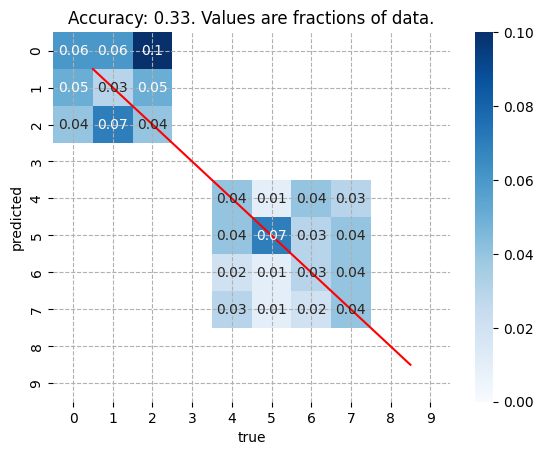

In [3]:
def plotConfusionMatrix(y_true:np.ndarray[int], y_pred:np.ndarray[int]):
    """
    Plots the confusion matrix for the classifications. Values are fraction of data.

    Args:
        y_true: True labels
        y_pred: Predicted labels
    """
    NUM_DIGIT = 10
    labels = set(y_true)
    num_label = NUM_DIGIT
    data_len = len(y_true)
    mat = tf.math.confusion_matrix(y_true, y_pred, num_classes=num_label)
    frc_mat = np.round(mat/data_len, 2)
    mask_mat = np.repeat(True, num_label*num_label)
    mask_mat = np.reshape(mask_mat, (num_label, num_label))
    for yt in range(num_label):
        for yp in range(num_label):
            if not np.isclose(frc_mat[yp, yt], 0):
                mask_mat[yp, yt] = False
    #
    _ = sns.heatmap(np.transpose(frc_mat), cmap="Blues", annot=True,
                    annot_kws={'fontsize': 10}, 
                    mask=np.transpose(mask_mat),
                 vmin=0)
    accuracy = np.round(balanced_accuracy_score(y_true, y_pred), 2)
    plt.grid(linestyle="--")
    plt.ylabel("predicted")
    plt.xlabel("true")
    plt.plot(range(1, num_label), range(1, num_label), c="red")
    plt.title("Accuracy: {accuracy}. Values are fractions of data.".format(accuracy = accuracy))
    plt.show()

# Tests
def mkydata(num_label=8, size=100):
    labels = list(range(num_label))
    if num_label < 4:
        raise ValueError("num_label > 3")
    missing_label = labels[3]
    y1 = np.random.randint(0, missing_label, size//2)
    y2 = np.random.randint(missing_label+1, num_label, size//2)
    return np.concatenate([y1, y2])
#
size = 100
y_true = mkydata()
y_pred = mkydata()
plotConfusionMatrix(y_true, y_pred)

## makeDigitData

In [4]:
def makeDigitData(datatype:str)->(np.ndarray, np.ndarray):
    """
    Uses last construction of the digit data. The image is flattened.

    Args:
        datatype: "testing", "training"
    Returns:
        ndarray: feature matrix
        ndarray: label vector
    """
    base_path = os.path.join(cn.DATA_MNIST_SMALL, datatype)
    ddirs = os.listdir(base_path)
    X_data = []
    y_arr = np.array([])
    for ddir in ddirs:
        this_ddir = os.path.join(base_path, ddir)
        ffiles = os.listdir(this_ddir)
        label_arr = np.repeat(int(ddir), len(ffiles))
        y_arr = np.concatenate((y_arr, label_arr))
        for ffile in ffiles:
            path = os.path.join(this_ddir, ffile)
            img = Image.open(path)
            mat = np.asarray(img)
            arr = mat.flatten()
            X_data.append(arr)
    X_mat = np.stack(X_data)
    y_arr = y_arr.astype(int)
    return X_mat, y_arr

# Tests
X_mat, y_data = makeDigitData(cn.TRAINING)
num_sample = np.shape(X_mat)[0]
assert(num_sample == np.shape(y_data)[0])
print("OK!")

OK!


## displayImage

In [5]:
def displayImage(dcts, rpix=28, cpix=28, nrow=2, ncol=5, is_plot=True, fontsize=14):
    """
    args:
        dcts: list-dict (key: digit, value: array)
        rpix: int (row pixels)
        cpix: int (column pixels)
        nrow: int (number of rows in the plot)
        ncol: int (number of columns in the plot)
        fontsize: int (size of title font; no title if =< 0)
    """
    if is_plot:
        _, axes = plt.subplots(nrow, ncol, figsize=(20, 15))
    for irow in range(nrow):
        for icol in range(ncol):
            if is_plot:
                ax = axes[irow, icol]
            pos = irow*ncol + icol
            if pos > len(dcts) - 1:
                break
            dct = dcts[pos]
            digit = list(dct.keys())
            digit = digit[0]
            arr = dct[digit]
            img_arr = np.reshape(arr, (rpix, cpix))
            img = Image.fromarray(img_arr)
            if is_plot:
                ax.imshow(img)
                ax.set_xticklabels([])
                ax.set_yticklabels([])
                if fontsize > 0:
                    ax.set_title("%d" % digit, fontsize=fontsize)

# Tests
rpix = 28
cpix = 28
dcts = []
for digit in range(7):
    dct = {digit: np.uint8(np.random.randint(0, 255, rpix*cpix))}
    dcts.append(dct)
displayImage(dcts, rpix=rpix, cpix=cpix, is_plot=False)
print("OK!")

OK!


## learnDigits

***Preparing the data. This can take 30 secs for so.
***Making in-memory test and training data.
***Constructing the model.


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 32)             │        25,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 7)              │           455 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 27,687 (108.15 KB)

 Trainable params: 27,687 (108.15 KB)

 Non-trainable params: 0 (0.00 B)

***Training the model.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


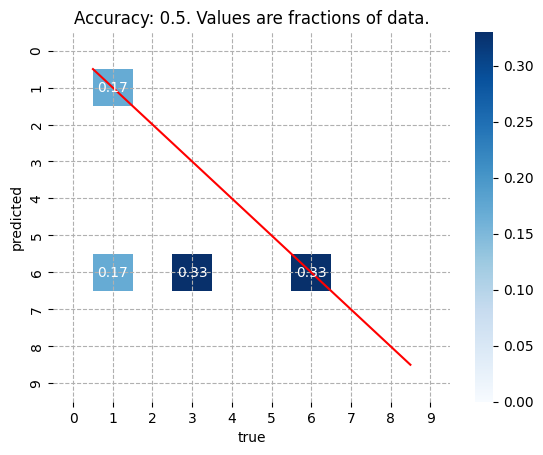

***Constructing the model.


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_3 (Dense)                 │ (None, 32)             │        25,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 7)              │           455 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 27,687 (108.15 KB)

 Trainable params: 27,687 (108.15 KB)

 Non-trainable params: 0 (0.00 B)

***Training the model.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


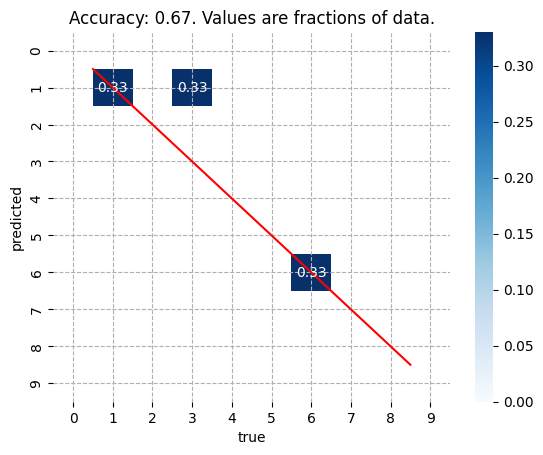

***Preparing the data. This can take 30 secs for so.
OK!


In [6]:
global X_training, y_training, X_testing, y_testing
LearnerInfo = collections.namedtuple("LearnerInfo",
      "model, X_training, y_training, X_testing, y_testing, history"
                                    )
def learnDigits(
    training_count:Optional[int]=None,
    digits:List[int]=range(10),
    hidden1_size:int=8,
    hidden2_size:int=16,
    num_epoch:int=5,
    training_verbose:int=0,
    is_confusion_matrix=True,
    is_model_summary=True,
):
    """
    1. Creates the data for the model from the full MNIST dataset.
    2. Constructs a sequential model with specified sizes of hidden layers
    3. Does prediction for the test set (20% the size of the training data)
    4. Displays accuracy and confusion matrix.

    Args:
        training_count: int (number of training images for each class)
            if None, use existing data.
        digits: list-int (digits/classes considered)
        hidden1_size: int (number of units in the first hidden layer)
        hidden2_size: int (number of units in the second hidden layer)
        num_epoc: int (number of epochs of training)
        verbose: int (verbosity for training)
    Returns:
        LearnerInfo
    """
    global X_training, y_training, X_testing, y_testing
    def makeDirs(error_msg=None):
        print("***Preparing the data. This can take 30 secs for so.")
        if training_count is None:
            if error_msg is None:
                error_msg = "Must specify training count to acquire new data."
            raise ValueError(error_msg)
        sub_dirs = [str(n) for n in digits]
        util.makeDigitDirs(train_count=training_count, sub_dirs=sub_dirs)
    #
    # Create the input data
    is_new_data = False
    if training_count is not None:
        makeDirs()
        is_new_data = True
    # Construct training and test data
    if (not "X_testing" in globals()) or is_new_data:
        print("***Making in-memory test and training data.")
        X_training, y_training = makeDigitData(cn.TRAINING)
        X_testing, y_testing = makeDigitData(cn.TESTING)
        is_new_data = True
    digit_diff = set(y_training).symmetric_difference(digits)
    if len(digit_diff) > 0:
        makeDirs(error_msg="Changed digits but didn't specify training_count.")
        X_training, y_training = makeDigitData(cn.TRAINING)
        X_testing, y_testing = makeDigitData(cn.TESTING)
    # Construct the model
    print("***Constructing the model.")
    max_class = max(y_training) + 1
    model = keras.Sequential(
        [
            keras.Input(shape=(X_training.shape[-1],)),
            layers.Dense(hidden1_size, activation="relu"),
            layers.Dense(hidden2_size, activation="relu"),
            layers.Dense(max_class, activation="softmax"),
        ]
    )
    model.compile(loss='categorical_crossentropy', metrics=['accuracy'])
    if is_model_summary:
        model.summary()
    categorical_y_training = to_categorical(y_training)
    # Train the model
    print("***Training the model.")
    history = model.fit(X_training, categorical_y_training, epochs=num_epoch,
                        batch_size=64,
                        verbose=training_verbose)
    
    y_pred = model.predict(X_testing).argmax(axis=1)
    # Evaluate the result
    if is_confusion_matrix:
        plotConfusionMatrix(y_testing, y_pred)
    return LearnerInfo(
        X_training=X_training, 
        y_training=y_training,
        model=model,
        X_testing=X_testing,
        y_testing=y_testing,
        history=history
    )

# Tests
try:
    learner_info = learnDigits(training_count=10, hidden1_size=32, hidden2_size=64, 
            num_epoch=5, digits = [1, 3, 6], training_verbose=0)
except Exception as e:
    assert(False)
# Use previous data
try:
    learnDigits(training_count=None, hidden1_size=32, hidden2_size=64, 
            num_epoch=5, digits = [1, 3, 6], training_verbose=0)
except Exception as e:
    assert(False)
# Changed digits
try:
    learnDigits(training_count=None, hidden1_size=32, hidden2_size=64, 
            num_epoch=5, digits = [1, 3, 6, 7], training_verbose=0)
    assert(False)
except Exception as e:
    pass
#
print("OK!")

In [7]:
learner_info.X_testing[0:1, :]

array([[  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,  21, 252, 111,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0, 138, 254, 145,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,  27, 234, 254, 115,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,  88, 254, 254,  63,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0

In [8]:
learner_info.model.predict(learner_info.X_testing[0:1, :]).argmax(axis=1)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


array([6])

In [9]:
set(learner_info.y_testing)

{1, 3, 6}

In [10]:
np.shape(learner_info.X_testing[0:2, :])

(2, 784)

In [11]:
np.shape(learner_info.X_testing)

(6, 784)

## Data Initialization

In [12]:
util.makeDigitDirs(train_count=5000, sub_dirs=range(10))
X_TRAINING_MAT, Y_TRAINING_ARR =  makeDigitData(cn.TRAINING)
X_TESTING_MAT, Y_TESTING_ARR =  makeDigitData(cn.TESTING)

In [13]:
np.shape(X_TRAINING_MAT), np.shape(Y_TRAINING_ARR), np.shape(X_TESTING_MAT), np.shape(Y_TESTING_ARR)

((50000, 784), (50000,), (9786, 784), (9786,))

In [14]:
X_TRAINING_MAT[0:2, 100:200]

array([[  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,  11,  34, 212, 253, 211,  86,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   

In [15]:
Y_TRAINING_ARR[0:2]

array([9, 9])

# An Anecdote on Data Quantity & Quality

Task: Build a learner that identifies if an image is a *plane* or a *bird*.

<img src="https://pngimg.com/uploads/birds/birds_PNG49.png" alt="drawing" width="200"/>
<img src="https://i.etsystatic.com/18604024/r/il/d40c9f/4484408200/il_1588xN.4484408200_rfpk.jpg" alt="drawing" width="200"/>
<img src="https://pngimg.com/uploads/plane/plane_PNG101208.png" alt="drawing" width="200"/>

**Larry Bird**
<img src="https://cdn.nba.com/manage/2018/10/larry-bird.jpg" alt="drawing" width="300"/>

We don't want pictures of Larry Bird in our training data!

**Data curation is essential.**

# MNIST Digit Data

<img src="https://upload.wikimedia.org/wikipedia/commons/f/f7/MnistExamplesModified.png" alt="drawing" width="400"/>

About 6,000 ``png` files for training each digit and 1,000 ``png`` files for testing.

<img src="https://github.com/joseph-hellerstein/keras/raw/main/docs/structure-of-mnist.png" alt="drawing" width="500"/>

# Common Sense Data Science for Classification

## Terminology

* Data consist of information collected for analysis. They described along two dimensions:
    * Sample. An instance of what is collected. Example: A single $28 \times 28$ image.
    * Feature. An attribute of a data item. Example: pixel 25, 27.
* Label. A classification of a data item. Example (for digit classification): "5".
* Prediction. The assignment of a label to a data item.
* Parameters. Constants used by the learner to do predictions.
* Training data. Data used by the learner to estimate parameters (e.g., via back propagation).
* Test data. Data used to evaluate the quality of a learner by comparing predictions with the labels of the test data. Test data are not part of training data.

## Guidelines

**You need much more data (samples times features) than parameters.**
Violating this leads to overfitting.

**Models should have as many parameters as required to achieve the desired quality (e.g., accuracy), but no more.**
This reduces the data requirements and the complexity of the model.

**A data item improves parameter estimation only in so far as it is independent of the other data.** There is no value to redundant data.

**We prefer models that have an intuitive explanation.** Intuitive models are more credible than a "black box".

# Tips for Computational Sanity

## Recommendations

1. Global variables
    1. Write once, read many in many cells.
    1. All capital letters
1. Local variables
    1. Used within a single cell
1. Functions
    1. Use functions to encapsulate workflow and avoid "name collisions" for variables.
    2. Functions definitions include a test (``assert``)

## Globals in this notebook

The globals reflect training and test data for MNIST.

In [16]:
np.shape(X_TRAINING_MAT), np.shape(Y_TRAINING_ARR), np.shape(X_TESTING_MAT), np.shape(Y_TESTING_ARR)

((50000, 784), (50000,), (9786, 784), (9786,))

# Model 1: Ideal Image for a Digit

## Approach - Ideal Image

* *Fitting*: Calculate the "ideal" for each class, the average value of each of the $28 \times 28$ pixels for all images in each class.
* *Predicting*: Choose the digit whose ideal image has the smallest distance from the test image.

Distance measure. Let $\bar{p}_{ki}$ be the $i$-th pixel in the flattened image for the ideal image of class $k$, and let $p_i$ be the $i$-th pixel in a test image. The distance from the test image to the ideal of class $k$ is
$$\sum_i (p_i - \bar{p}_{ki})^2$$.

## Fitting

Pseudo code

    for digit in digits
        ideal_image = mean of pixels for digit
        ideal_images.append(ideal_image)
    return ideal_images

In [17]:
# Training
def fitIdeal(training_count=600, num_cluster=1):
    """
    Constructs ideal images and their classes.

    Args:
        training_count: int (size of the training set for a digit)
        num_cluster: int (number of clusters in a digit training set)

    Returns:
        list-dict (key: digit, value: array of mean pixels)
    """
    dcts = []
    for digit in range(10):
        util.makeDigitDirs(train_count=training_count, sub_dirs=[digit])
        X_training, _ = makeDigitData(cn.TRAINING)
        if num_cluster == 1:
            dct = {digit: np.mean(X_training[:, :], axis=0)}
            dcts.append(dct)
        else:
            kmeans = KMeans(n_clusters=num_cluster, random_state=0, n_init="auto").fit(X_training)
            for cluster_center in kmeans.cluster_centers_:
                dct = {digit: cluster_center}
                dcts.append(dct)        
    return dcts

# Tests
dcts = fitIdeal(training_count=10)
assert(isinstance(dcts, list))
assert(isinstance(dcts[0], dict))
if False:
    displayImage(dcts)
else:
    print("OK!")

OK!


In [18]:
FITTED_DCTS = fitIdeal()

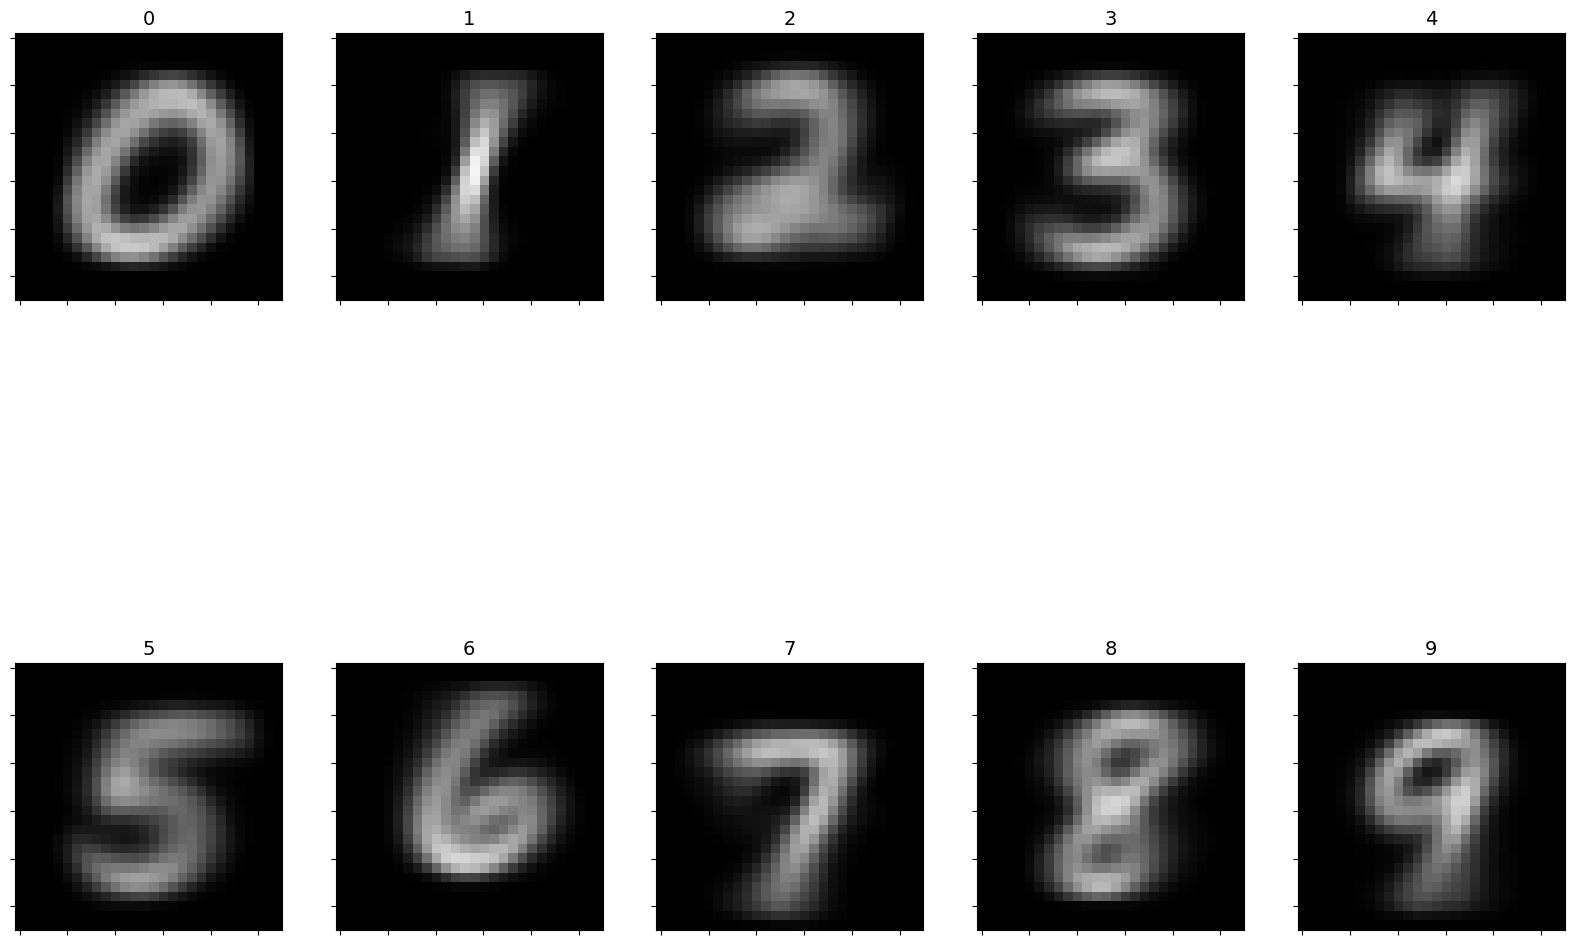

In [19]:
displayImage(FITTED_DCTS)

The parameters in this model are the average pixels.

## Prediction

In [20]:
def oldpredictIdeal(test_X_mat, dcts=FITTED_DCTS):
    """
    Predicts the classes for the flattened_test_arr

    Args:
        test_X_mat: mat-int (x, 768)
        dcts: list-dict (key: digit, value: array)
    Returns:
        arr-int (predictions)
    """
    num_test = np.shape(test_X_mat)[0]
    num_ideal = len(dcts)
    pos_to_class = [getKey(d) for d in dcts]
    predictions = []
    for test_idx in range(num_test):
        test_arr = test_X_mat[test_idx, :]
        distances = []
        for dct in dcts:
            key = getKey(dct)
            ideal_arr = dct[key]
            distances.append(np.sum((test_arr - ideal_arr)**2))
        distance_arr = np.array(distances)
        min_pos = distance_arr.argmin()
        predictions.append(pos_to_class[min_pos])
    # Calculate predictions
    return np.array(predictions)

# TESTS
matches = oldpredictIdeal(X_TESTING_MAT) - Y_TESTING_ARR
num_correct = np.sum([v == 0 for v in matches])
assert(num_correct > 15)
print("OK!")

OK!


In [21]:
def predictIdeal(test_X_mat, dcts=FITTED_DCTS):
    """
    Predicts the classes for the flattened_test_arr

    Args:
        test_X_mat: mat-int (x, 768)
        dcts: list-dict (key: digit, value: array)
    Returns:
        arr-int (predictions)
    """
    num_test = np.shape(test_X_mat)[0]
    num_ideal = len(dcts)
    # Construct the fitted data
    digit_arr = np.array([getKey(d) for d in dcts])
    centroid_mat = np.array([d[k] for d, k in zip(dcts, digit_arr)])
    predictions = []
    for test_idx in range(num_test):
        test_arr = test_X_mat[test_idx, :]
        distance_mat = np.subtract(centroid_mat, test_arr)
        distance_mat = np.multiply(distance_mat, distance_mat)
        distance_arr = np.sum(distance_mat, axis=1)
        min_pos = distance_arr.argmin()
        predictions.append(digit_arr[min_pos])
    # Calculate predictions
    return np.array(predictions)

# TESTS
matches = predictIdeal(X_TESTING_MAT) - Y_TESTING_ARR
num_correct = np.sum([v == 0 for v in matches])
assert(num_correct > 15)
print("OK!")

OK!


Accuracy assessment.

# Evaluating Model Quality

## Accuracy

Accuracy is the fraction of the test set for which the predicted label is the true label. This is useful for "one shot" classification.

## Precision and Recall

For retrieval tasks, we are doing classification of many samples. An example of this is an Internet search for web pages with desired phrases. The learner operates as follows:

    for data_item in data:
        if learner.predict(data_item) in desired class
            output the data_item

Because the foregoing operates on a batch of samples, we have slightly different metrics than the "single shot" scenario.
          
* **Precision**: What fraction of the output data are *true* members of the desired class
* **Recall**: What fraction of all data in the true class are in the output data

## Confusion Matrix

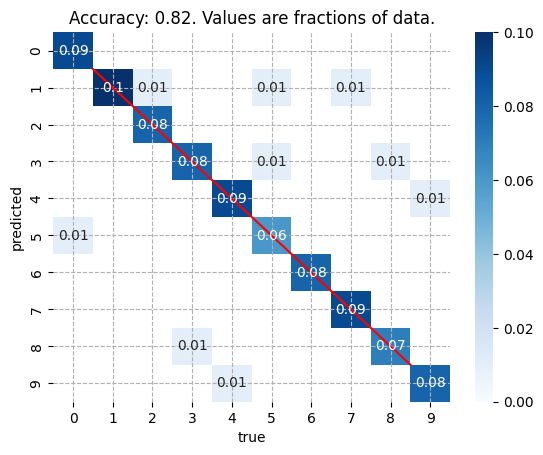

In [22]:
y_pred_arr = predictIdeal(X_TESTING_MAT, dcts=FITTED_DCTS)
plotConfusionMatrix(Y_TESTING_ARR, y_pred_arr)

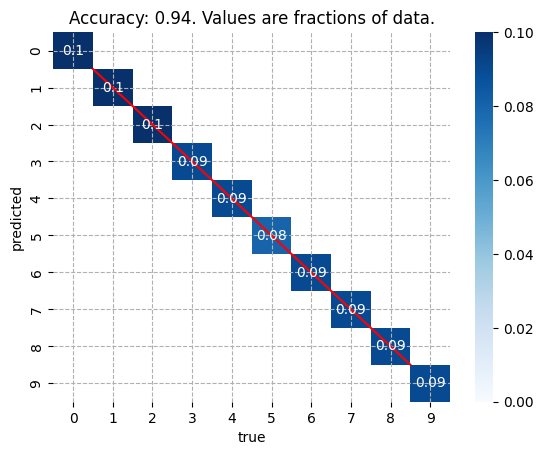

In [23]:
fitted_dcts = fitIdeal(training_count=5000, num_cluster=20)
y_pred_arr = predictIdeal(X_TESTING_MAT, dcts=fitted_dcts)
plotConfusionMatrix(Y_TESTING_ARR, y_pred_arr)

In [24]:
%%time
fitted_dcts = fitIdeal(training_count=600, num_cluster=30)

CPU times: user 16.3 s, sys: 19.1 s, total: 35.4 s
Wall time: 8.75 s


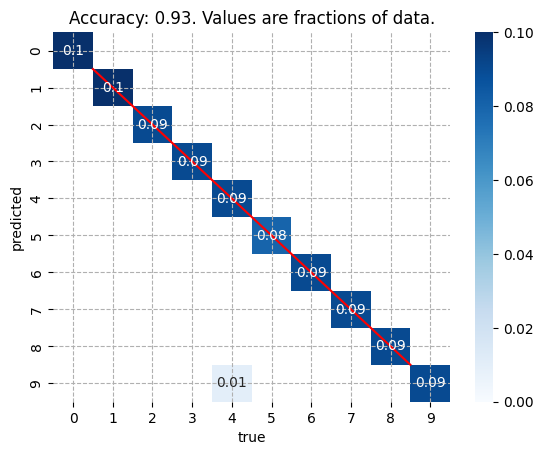

CPU times: user 2.51 s, sys: 2.32 s, total: 4.83 s
Wall time: 3.84 s


In [25]:
%%time
y_pred_arr = predictIdeal(X_TESTING_MAT, dcts=fitted_dcts)
plotConfusionMatrix(Y_TESTING_ARR, y_pred_arr)

# Model 2: Neural Network

## Model

## Quality assessment

# Model 3: Multiple Ideal Images for a Digit

Approach -- Have more than one ideal for each digit to account for common variations.

More ideals likely improves model quality. But it also increases model the number of parameters.

## Clustering

<img src="https://github.com/joseph-hellerstein/keras/raw/main/docs/clusters.png" alt="drawing" width="500"/>

## Clustering code

In [26]:
%%capture
image_mat = X_TRAINING_MAT[range(20), :]
image_dcts = [{n: image_mat[n, :]} for n in range(20)]
displayImage(image_dcts, nrow=4, ncol=5, fontsize=-1)

In [27]:
%%capture
image_mat = X_TRAINING_MAT[range(20), :]
image_idxs = np.array(range(20))
kmeans = KMeans(n_clusters=4, random_state=0, n_init="auto").fit(image_mat)
idxs = []
classes = []
for cls in range(4):
    sel = kmeans.labels_ == cls
    idxs.extend(list(image_idxs[sel]))
    classes.extend(list(np.repeat(cls, sum(sel))))
cluster_dcts = [{classes[n]: image_mat[idxs[n], :]} for n in range(20)]
displayImage(cluster_dcts, nrow=4, ncol=5, fontsize=40)

In [28]:
def plotSSW(digit, sizes=None, ax=None, is_plot=True):
    """
    Plots the sum of squares within the classes

    Args:
        digit - int
    Returns:
        KMeans
    """
    if sizes is None:
        sizes = [1, 5, 8, 10, 12, 15, 18, 20]
    ssq_dct = {}
    for size in sizes:
        idxs = Y_TRAINING_ARR == digit
        kmeans = KMeans(n_clusters=size, random_state=0, n_init="auto").fit(X_TRAINING_MAT[idxs, :])
        ssq_dct[size] = kmeans.inertia_
    if is_plot:
        if ax is None:
            _, ax = plt.subplots(1)
        ax.plot(ssq_dct.keys(), ssq_dct.values())
        ax.set_title(str(digit), fontsize=20)
        ax.set_xlabel("no. classes")
        ax.set_ylabel("sum of squares")
        ax.set_ylim([0, 2*1e10])
    return kmeans

# Tests
result = plotSSW(1, sizes=[1,3], is_plot=False)
assert("KMeans" in str(type(result)))
print("OK!")

OK!


Training data with clustering

In [29]:
def plotDigitClassSizes(is_plot=True, **kwargs):
    """
    Plots the class sizes and SSW.

    Returns:
        list-KMeans
    """
    nrow = 2
    ncol = 5
    if is_plot:
        figure, axes = plt.subplots(nrow, ncol, figsize=(20, 8))
    kmeans = []
    for irow in range(nrow):
        for icol in range(ncol):
            digit = irow*ncol + icol
            if is_plot:
                ax = axes[irow, icol]
            else:
                ax = None
            kmeans.append(plotSSW(digit, ax=ax, is_plot=is_plot, **kwargs))
            if irow == 0:
                if ax is not None:
                    ax.set_xlabel("")
            if icol > 0:
                if ax is not None:
                    ax.set_ylabel("")
    return kmeans

# Tests
results = plotDigitClassSizes(sizes=[1, 20], is_plot=False)
assert(isinstance(results, list))
assert("KMeans" in str(type(results[0])))
print("OK!")

OK!


## Clustering and Number of Clusters

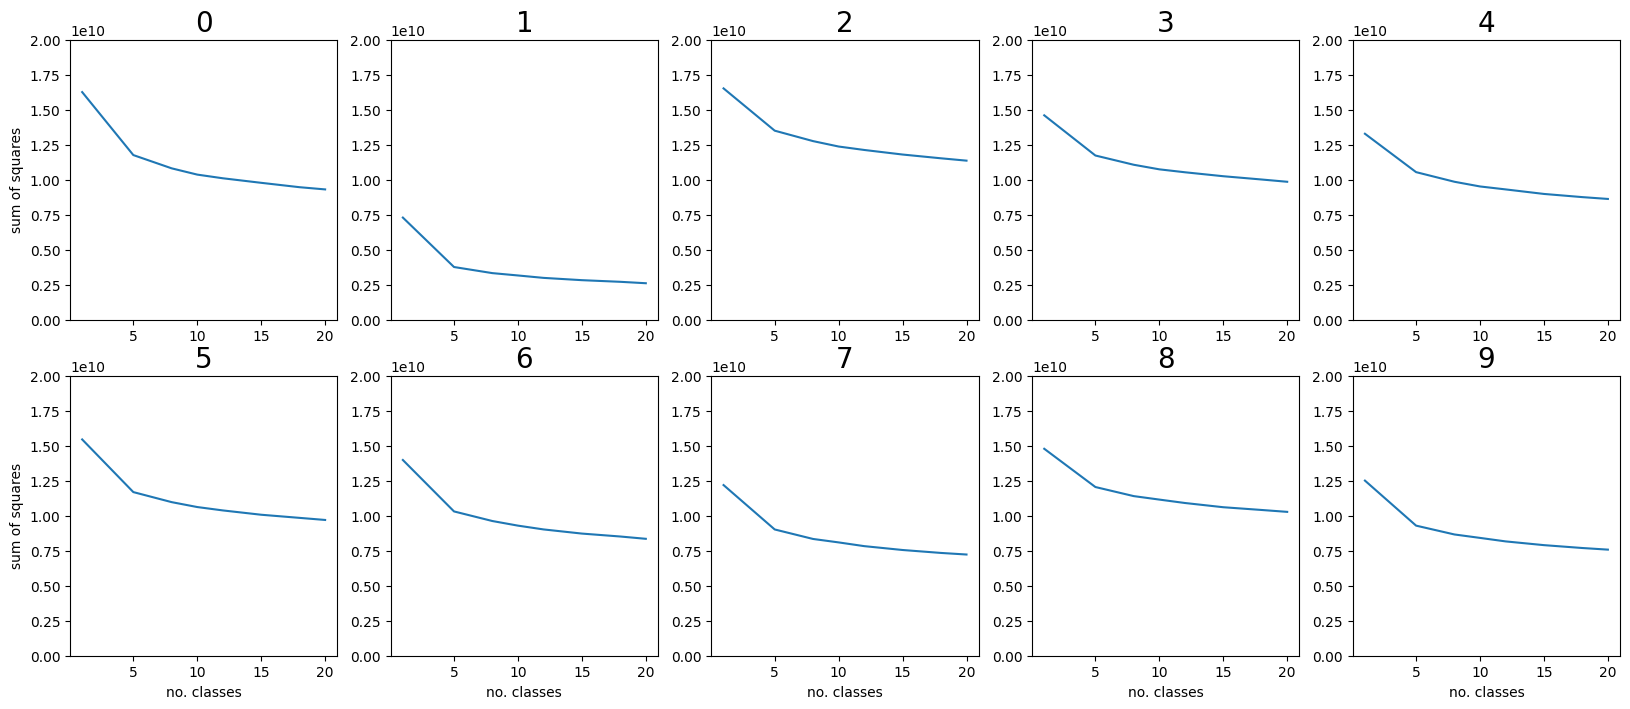

In [30]:
_ = plotDigitClassSizes()

## Evaluate Model Quality

1. Display images by using refined clusters.
1. Calculate the number of parameters

In [31]:
util.makeDigitDirs(train_count=1000, sub_dirs=range(10))
X_testing, y_testing = makeDigitData(cn.TESTING)

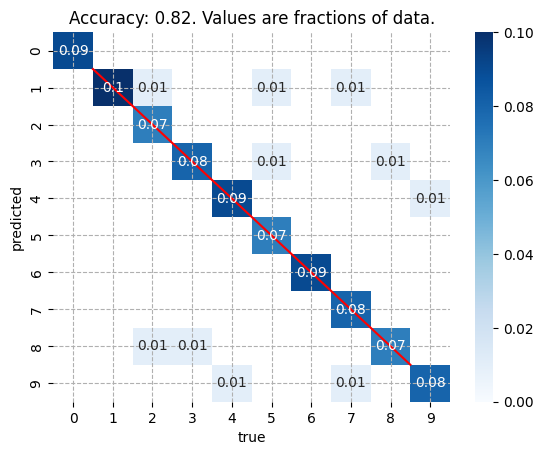

In [36]:
y_pred = predictIdeal(X_testing, dcts=FITTED_DCTS)
plotConfusionMatrix(y_testing, y_pred)

Let's start with "3" and "7" since this is likely an easier task.

The first step is to figure out the inputs and outputs for what we want to learn. We will be classifying images as either a "3" or a "7". So, there will be two numeric outputs that will indicate the probability of each digit.

The inputs will be the pixels in the ``png``. These are $28 \times 28 = 768$. So there will be 768 input units.

![image](https://www.mathworks.com/discovery/neural-network/_jcr_content/mainParsys/band_copy_copy/mainParsys/lockedsubnav/mainParsys/columns/a32c7d5d-8012-4de1-bc76-8bd092f97db8/image_copy.adapt.full.medium.svg/1710244830270.svg)

3, 7 gives good accuracy w/500.

In [ ]:
learnDigits(
    training_count=500,
    digits=[1, 8], training_verbose=1,
    is_confusion_matrix=False,
)

# What is a model and how do we evaluate it?

1. Data
1. Inputs to learner and outputs from learner
1. Structure of the learner

The model depends on the task.
1. Classification.
    1. How many classes?
    2. Use case
       1. "Single shot" - Does this picture include my daughter?
       2. Retrieval -- Find all photos of my daughter
1. Regression - Predict numeric values
   1. How old is this brain?
   2. How deep is the snow?

Model evaluation depends on the task
1. Single shot - accuracy
2. Retrieval
   1. Precision - what fraction of the pictures actually contain my daughter
   2. Recall - what fraction of the pictures with my daughter are recalled

Metrics
1. Accuracy
2. Precision
3. Recall

The confusion matrix and derivation of metrics from it.

Factors affecting model quality
1. Quality and amount of data
2. Size of the model (in number of parameters)
3. Number of training epocs
4. Complexity of the problem

The foregoing also impact the training time

## Construct full data of features (X) and labels (y)

## Model then curate

1. Create a small dataset (1000 images) with 3 digits.
2. Evaluate quality

# 